In [197]:
import pandas as pd
import numpy as np
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
import graphviz
import pydot

In [149]:
data=pd.read_csv('conversion_data.csv',index_col=False)

read the data into a dataframe using pandas module

In [150]:
data.describe()
#summarize the data information#

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [151]:
data['country'].value_counts()
# Since python describe function does not support non-numerical values, I use value count to figure out the corresponding count
# related different countries

US         178092
China       76602
UK          48450
Germany     13056
Name: country, dtype: int64

In [152]:
data.nlargest(5,'age')

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1
265167,US,79,1,Direct,1,0
192644,US,77,0,Direct,4,0
154217,US,73,1,Seo,5,0


In [153]:
data=data.drop(data.index[[90928,295581]])
## remove two entries with unusual ages

In [154]:
data.nlargest(5,'age')

,country,age,new_user,source,total_pages_visited,converted
265167,US,79,1,Direct,1,0
192644,US,77,0,Direct,4,0
154217,US,73,1,Seo,5,0
208969,US,72,1,Direct,4,0
114485,US,70,1,Ads,9,0


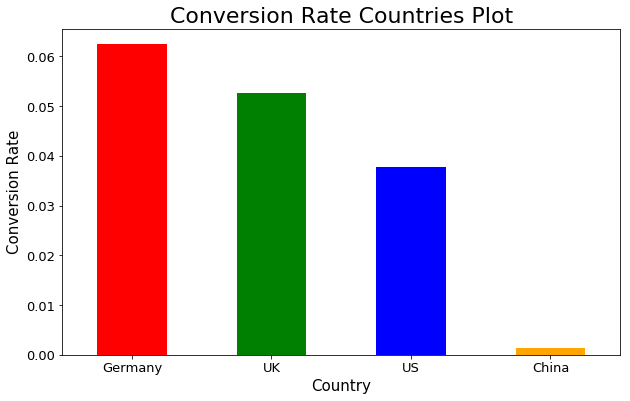

In [155]:
countries=['China',"US","UK","Germany"]
mean_conversion=data.groupby(['country'])['converted'].mean().sort_values(ascending=False)
ax = mean_conversion.plot(kind='bar', figsize=(10,6), color=['red','green','blue','orange'], fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Conversion Rate Countries Plot", fontsize=22)
ax.set_ylabel("Conversion Rate", fontsize=15)
ax.set_xlabel("Country",fontsize=15)
plt.xticks(rotation=0)
plt.show()
## Bar plot display different mean conversion rates based on countires##

In [156]:
mean_conversion

country
Germany    0.062428
UK         0.052612
US         0.037801
China      0.001332
Name: converted, dtype: float64

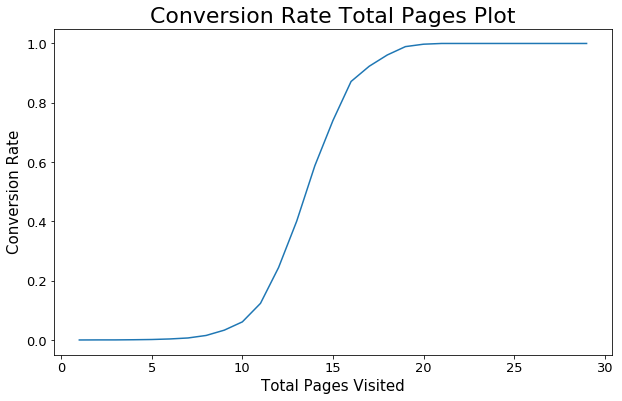

In [157]:
mean_conversion_1=data.groupby(['total_pages_visited'])['converted'].mean().sort_values(ascending=False)
ax = mean_conversion_1.plot(kind='line', figsize=(10,6), fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Conversion Rate Total Pages Plot", fontsize=22)
ax.set_ylabel("Conversion Rate", fontsize=15)
ax.set_xlabel("Total Pages Visited",fontsize=15)
plt.xticks(rotation=0)
plt.show()
## Line plot shows that as the number of pages visited increases the conversion rates increases, and it will eventually hit 1.0
## when number of pages exceeds 20##

In [158]:
## Move forward to the modeling part, typically, for binary classification problems, we have the following choices##
#1 Decision Rule
#2 Rule Based 
#3 Logistic Regression
#4 Random Forest with partial dependency plot
# Don't spend too much optimizing the model, but pay more attention to explaining why you pick this model#

In [159]:
def factorize_col(data,col):
    data[col]=list(data[col].factorize())[0]
## define a user function to factorize categories into numerical values

In [160]:
factorize_col(data,'country')
factorize_col(data,'new_user')
factorize_col(data, 'source')

In [161]:
X=data.iloc[:,0:5]
y=data["converted"].values
## X represents the training set with all features
## y is the conversion rate, something we want to predict
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
## split the data into train and test data, first fit the model to train data, I call it train data cuz I will train the model 
## on this data. The train set consists of much more entries than test set in that I want to ensure the model is appropriately
## trained. Test data is only used for model evaluation after the training ends.

In [162]:
print(data['country'].value_counts())
print(data['source'].value_counts())

1    178092
2     76602
0     48449
3     13055
Name: country, dtype: int64
1    155039
0     88739
2     72420
Name: source, dtype: int64


In [163]:
regressor = RandomForestClassifier(random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
## fit the random forest classifier to the training set, evaluate the model performance on test set

In [164]:
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[60933   340]
 [  625  1342]]
0.9847406704617331


In [165]:
## Before we evaluate the model results, we need to establish a baseline, a sensible measure we want to beat with our model
## If the model can't beat the baseline, it will be a failure and I would try a difffernt approach and the machine learning model 
## is not right for this problem. 
## In the problem, the baseline is the error if I simply predict the average conversion rate for all users. 

baseline=[y_train.mean()]*len(y_test)
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline - y_test)
print('Average baseline error: ', round(np.mean(baseline_errors), 2),'degrees.')


# Calculate the absolute errors
errors = abs(y_pred - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

## The average baseline error is 0.06 while the model MAE  is only 0.02, we cut the error by a half by applying random forest for 
# prediction, it's safe to say that random forest has done a great job for predicting conversion_rate with the given features.  

Average baseline error:  0.06 degrees.
Mean Absolute Error: 0.02 degrees.


In [166]:
feature_list=['country','age','new_user','source','total_page_visited']
# Use variable importance to quantify the usefulness of all features in the entire random forest, 
# the relative importance represents how much by including this value improves the prediction

# Get numerical feature importances
importances = list(regressor.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: total_page_visited   Importance: 0.8
Variable: age                  Importance: 0.1
Variable: country              Importance: 0.04
Variable: new_user             Importance: 0.04
Variable: source               Importance: 0.02


In [167]:
## Total Page Visited is the most important one, but it is probably the least "actionable". People visit more pages cuz they already
## want to buy, you want to buy so you click on the page several times

## Let's rebuild our model without total_pages visited
X=data.iloc[:,0:4]
y=data["converted"].values
## X represents the training set with all features
## y is the conversion rate, something we want to predict
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [176]:
# retrain the random forest classifier to the training set without total_pages_visited variable
regressor = RandomForestClassifier(random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [177]:
baseline=[y_train.mean()]*len(y_test)
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline - y_test)
print('Average baseline error: ', round(np.mean(baseline_errors), 2),'degrees.')


# Calculate the absolute errors
errors = abs(y_pred - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
## still a huge improvment over the baseline 

Average baseline error:  0.06 degrees.
Mean Absolute Error: 0.03 degrees.


In [202]:
feature_list=['country','age','new_user','source']
rf_small = RandomForestClassifier(n_estimators=10, max_depth = 3)
rf_small.fit(X_train, y_train)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png')